In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
# 给一个随机数种子，使得每次运行得到的随机数是相同的
rng = np.random.default_rng(seed=0)  
# 数据导入
path = ".data/sst.mnmean.nc"
# 丢弃一个不必要导入的变量:time_bnds
ds = xr.open_dataset(path, drop_variables=["time_bnds"])
# 下述代码需几分钟导入数据
ds = ds.sel(time=slice("1960", "2018")).load()

# 基础计算

## 基本计算

### <font color=ff8888>加减乘除</font> 和 _**<font color = ff8888>numpy</font>**_ 函数

xarray 的 DataArray 和 DataSet 对象可以无缝地使用计算操作符（如+, -, *, /）和 numpy 数组函数。  
  
下面我们将海温数据的 摄氏温度 改写为 开尔文温度 为例说明上述问题。  
可以发现再进行计算操作后，数据集的维度和坐标都没有发生变化。

In [2]:
sst_kelvin = ds.sst+270

下面我们来尝试一下用更为复杂的函数进行计算。

In [3]:
np.log(sst_kelvin ** 2).coords

Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01

### _**<font color = skyblue>apply_ufunc</font>**_ 函数的使用

上面可以调用 **<font color=skyblue>np.log(ds)</font>** 并使其在 xarray 中“正常工作”是非常幸运的，但是 <font color=ff8888>并非所有的库都能直接在 xarray 中正常工作</font> 。

_**<font color=skyblue size=4>xr.apply_ufunc(<font color=ff8888>function</font>, <font color=orange>vars</font>)</font>**_

In [4]:
xr.apply_ufunc(np.log, sst_kelvin**2).coords

Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01

apply_ufunc 函数功能强大，有很多可选参数以便进行复杂操作  
  
更多可查阅：http://xarray.pydata.org/en/latest/generated/xarray.apply_ufunc.html

## 降维计算： _**<font color=skyblue>mean, sum, min, max, std, ...</font>**_

In [5]:
sst = ds.sst

### 根据 _**<font color=ff8888>axis</font>**_ 降维

_**<font size=4 color=skyblue><font color=orange>xarray</font>.mean( <font color=orange>axis</font> )</font>**_

在numpy中，如果要进行对某一维度以某种方式（譬如取最大、小值，平均值）进行降维，可通过指定axis参数实现。比如：

In [6]:
arr = np.arange(20).reshape(5,4)
arr.sum(axis = 0)

array([40, 45, 50, 55])

对于xarray对象，如sst：如果要对时间方向上以平均的方法进行降维，与numpy中的方法类似，可写为

In [7]:
# 对第0维度（维度time）以平均的方法进行降维
sst.mean(axis = 0).coords

Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0

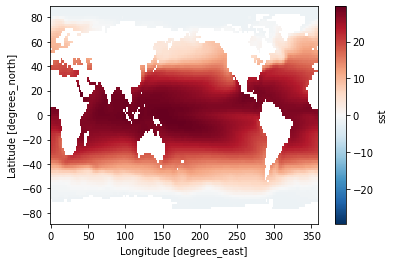

In [8]:
sst.mean(axis = 0).plot()

那么如果要对经纬方向上同时进行降维应当如何写呢？只需要将同时降维的维度号用小括号包含在内即可。

In [9]:
# 对第1、2维度（维度lat、lon）以平均的方法进行降维
sst.mean(axis=(1, 2)).coords

Coordinates:
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01

通过对经纬方向的降维，我们现在得到了一个时间序列，这个时间序列描述了全球平均表面海温（SST）的变化。

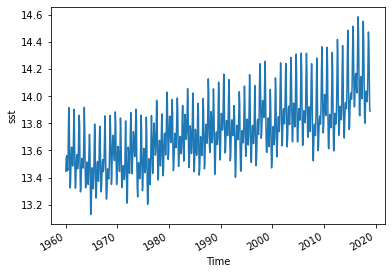

In [10]:
sst.mean(axis=(1, 2)).plot()

可以注意到每一年中全球平均海温存在明显的季节振荡（变化），这个季节振荡的去除可利用 **<font color=skyblue>resample</font>** 方法得到，后续将会详细介绍这个功能的使用方法。

### 根据 _**<font color=ff8888>dim</font>**_ 降维

_**<font size=4 color=skyblue><font color=orange>xarray</font>.mean( <font color=orange>dim</font> )</font>**_

除了使用类似于numpy中的对数轴的降维方法，也可以使用xarray中独特、便捷的方法。这种方法无需记忆数轴所对应的维度名称。  
  
若要求解多年SST的平均场，可以通过对时间维取平均降维实现。这可以定义dim这个参数实现。

In [11]:
sst.mean(dim="time").coords

Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0

当然除了mean方法，其他的numpy标准降维方法也是可以使用的，如min（取最小值）, max（取最大值）, sum（求和）, std（求解标准差）等。

### 控制缺失值 _**<font color=ff8888>skipna</font>**_

上述这些操作会自动跳过缺失值，这对于某些数据的处理是非常有利的，比如SST仅在海洋上有值，但陆地上没有值，利用.mean进行计算时会自动忽略缺失值。  
  
为进一步说明，下面举一个例子

In [12]:
xr.DataArray([1, 2, np.nan, 3]).mean()

<xarray.DataArray ()>
array(2.)

如果要考虑缺失值的计算（虽然通常没有此类需求），则需在括号中添加参数skipna=False.

In [13]:
xr.DataArray([1, 2, np.nan, 3]).mean(skipna=False)

<xarray.DataArray ()>
array(nan)

### 练习

在经度和纬度上均取变量sst的平均值。绘制一个简单的时间序列图：

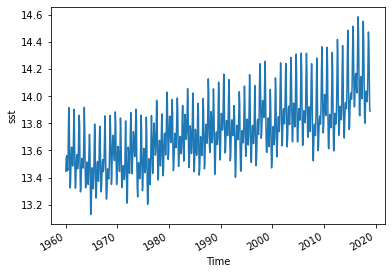

In [14]:
# 在这里写你的代码
sst.mean(dim=("lat", "lon")).plot()

## 广播

广播（Broadcasting）是指具有不同维度数组的对齐。  

基于数组形状的 Numpy 广播规则有时可能难以理解和记住，   
Xarray相较Numpy提供了按维度名称（而非数组形状）进行广播的方法，免去了记忆的困难。  

为说明广播在计算中的作用，下面将创建一个与纬度有关的权重因子。这个权重因子常用于描述规则经纬网格上数据的面积权重系数。  
  
下述的代码创建了一个权重系数，ds.lat可以获取ds的纬度数组（离散角度值）。因为后续的np.cos()只能接受弧度进行计算，这儿利用np.deg2rad函数将角度转换为弧度，再利用np.cos()计算余弦值。  
  
总而言之，本质上权重系数即为各个纬度上的余弦值。

In [15]:
weights = np.cos(np.deg2rad(ds.lat))
weights.coords

Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0

此时，权重因子仅有一个维度。如果我们将这个权重因子与SST相乘会发生什么呢？  
  
应当注意这个相乘不是矩阵相乘，而是对应位置的元素彼此相乘。  

In [16]:
(ds.sst * weights).coords

Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01

如果要广播的数组共享一个维度名称，但坐标维度不同。  
在这种情况下，广播将会使用xarray的默认对齐设置（即取两者变量索引的交集）进行对齐（包括使用NaN填充缺失值）。  
  
如果这不是想要的结果，最好在广播之前显式调用 _**<font color=skyblue>align</font>**_ 并指定参数使得两个数组得以对齐。

## 赋权降维

_**<font size=4 color=skyblue><font color=orange>DataArray</font>.weighted( <font color=orange>weights</font> ) , <font color=orange>Dataset</font>.weighted( <font color=orange>weights</font> )**_

xarray目前支持DataArray和Dataset对象，对于这两个对象的赋权降维可采用 DataArray.weighted() 和 Dataset.weighted() 方法。  
目前支持带权重的以平均（mean）和求和（sum）方法降维。  

为说明赋权降维，下面先创建一个关于降水数据的DataArray和一个权重的DataArray.

In [17]:
prec = xr.DataArray(
    [50, 10, 0.9], 
    dims=("month"), 
    coords= {"month":("month", [1, 2, 3])}
    )
prec.coords

Coordinates:
  * month    (month) int64 1 2 3

In [18]:
weights = xr.DataArray(
    [31, 28, 31], 
    dims=("month"), 
    coords= {"month":("month", [1, 2, 3])}
    )
weights

<xarray.DataArray (month: 3)>
array([31, 28, 31])
Coordinates:
  * month    (month) int64 1 2 3

接下来对prec以weights为权重创建权重对象

In [19]:
weighted_prec = prec.weighted(weights)
weighted_prec

DataArrayWeighted with weights along dimensions: month

计算加权和：50x31 + 10x28 + 0.9x31

In [20]:
weighted_prec.sum()

<xarray.DataArray ()>
array(1857.9)

等价于：

In [21]:
(prec*weights).sum()

<xarray.DataArray ()>
array(1857.9)

计算加权平均：( 50x31 + 10x28 + 0.9x31 ) / (31+28+31)

In [22]:
weighted_prec.mean(dim = "month")

<xarray.DataArray ()>
array(20.64333333)

等价于：

In [23]:
(prec*weights).sum() / weights.sum()

<xarray.DataArray ()>
array(20.64333333)

### 源数据存在 <font color = ff8888>缺失值</font>和某些特殊计算的情况

如果原数据存在缺失值np.nan时，赋权降维将得到正确的结果。  

In [24]:
data = xr.DataArray([np.nan, 2, 4])
weights = xr.DataArray([8, 1, 1])
data.weighted(weights).mean()

<xarray.DataArray ()>
array(3.)

而利用 (data * weights).sum() / weights.sum() 公式进行计算，得到的结果是不正确的  
不正确的原因在于某一点没有值，但其权重却参与了计算，会使得整体值减小。

In [25]:
(data*weights).sum()/weights.sum()

<xarray.DataArray ()>
array(0.6)

### 实际案例：平均SST的计算

In [26]:
# 数据导入
path = ".data/sst.mnmean.nc"
p = '#ff9988'
# 丢弃一个不必要导入的变量
ds = xr.open_dataset(path, drop_variables=["time_bnds"])
ds = ds.sel(time=slice("1960", "2018")).load()
weights = np.cos(np.deg2rad(ds.lat))

尝试一下以下方法对带权重的空间平均SST进行计算，就如下述代码所示  
  
没有考虑缺厕值问题，导致结果偏小

Text(0.5, 1.0, 'This is wrong!')

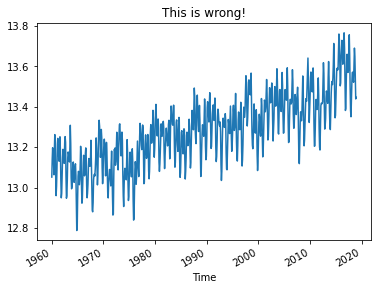

In [27]:
sst_mean = ((ds.sst * weights).sum(dim="lat") / weights.sum(dim="lat")).mean(dim="lon")
sst_mean.plot()
plt.title("This is wrong!")

就一般而言，多维数组上的赋权降维是复杂的。为了使操作更简单，xarray提供了一种赋权降维的机制。  
这个机制通过创建一个特殊的中间DataArrayWeighted对象来实现这个目的，从而能够对数组使用各类的降维操作。  
  
下述代码对DataArray对象给予了.weighted()方法，括号内填入了权重。  
  
运行的结果创建了一个关于DataArray的权重对象（DataArrayWeighted），并且这个权重是伴随着维度lat（纬度）变化的。  
  
接着对DataArray这个权重对象同时在在维度lon, lat上取平均。这时我们便获得了一个正确的全球平均SST.

Text(0.5, 1.0, 'Correct Global Mean SST')

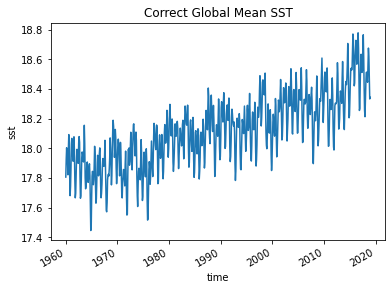

In [28]:
sst_weighted = ds.sst.weighted(weights)
sst_weighted.mean(dim=("lon", "lat")).plot()
plt.title("Correct Global Mean SST")

# Groupby 分组

Groupby是Pandas包中比较重要的一种聚合方法  
xarray借鉴了Pandas包中groupby功能，在xarray的DataArrays和Datasets上实现分割（split）、应用（apply） 和 组合（combine）  

为提供一个实际案例，下面考虑某个格点上的SST时间序列。

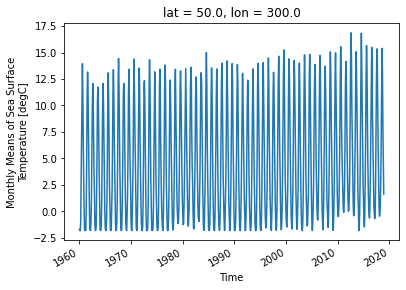

In [29]:
ds.sst.sel(lon=300, lat=50).plot()

## 根据时间分组

### 创建时间变量的 **<font color=ff8888>待索引对象</font>**

In [30]:
ds.time.dt

利用.dt.month提取各个时间的月份数据

In [31]:
ds.time.dt.month.shape #提取月份

(708,)

利用.dt.year提取各个时间的年份数据

In [32]:
ds.time.dt.year.shape # 提取年

(708,)

### 根据时间索引，创建 **<font color=ff8888>groupby对象</font>**

_**<font color=skyblue size=4><font color=orange>ds</font>.groupby( <font color=orange>ds.time</font>.dt.month )</font>**_  
_**<font color=skyblue size=4><font color=orange>ds</font>.groupby( "<font color=orange>time</font>.month" )</font>**_  

类似于Pandas包中的groupby的思想，我们利用ds.groupby()函数将月份作为键（唯一值）来对原数据进行分离。  
本质是即把各年的某个月的数据放到了一组。

In [33]:
gb = ds.groupby(ds.time.dt.month) # 根据月份进行分组
gb

DatasetGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

如果说时间参数变量已经包含在原数据集中（这也是通常出现的情况），可以使用xarray中更为简洁的方法，即"time.month". 这与ds.time.dt.month实现的操作是一致的。

In [34]:
gb = ds.groupby("time.month")
gb

DatasetGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

In [35]:
ds.groupby("time.year")

DatasetGroupBy, grouped over 'year'
59 groups with labels 1960, 1961, 1962, ..., 2017, 2018.

In [36]:
ds.groupby("time.season")

DatasetGroupBy, grouped over 'season'
4 groups with labels 'DJF', 'JJA', 'MAM', 'SON'.

### 迭代访问 **<font color=ff8888>groupby对象</font>**

经过上面的分组操作后，原数据已经拆分成12个组（groups），放置在变量gb中。  
对于这12个组，可通过循环进行遍历。迭代器返回各个组的键（组名）和值（与该组相对应的实际数据集）。

In [37]:
for group_name, group_ds in gb:
    # 当第一个循环结束时，停止遍历gb
    display(group_ds) 
    break

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 59)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-01 1961-01-01 ... 2018-01-01
Data variables:
    sst      (time, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2021-01-01

### 逐个访问 **<font color=ff8888>groupby对象</font>**

除了可以使用循环的方法对各个分组进行遍历，也可直接使用python中 **<font color=ff8888>列表</font>** 的访问方法访问各个分组。  
通过对list对象的第一个分组的访问可以获得分组名称和对应的xarray数据.  
  
先来尝试访问一下第一个（python中的第一个元素的索引由0开始）分组的信息

In [38]:
list(gb)[0] #访问第一个分组

(1,
 <xarray.Dataset>
 Dimensions:  (lat: 89, lon: 180, time: 59)
 Coordinates:
   * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
   * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
   * time     (time) datetime64[ns] 1960-01-01 1961-01-01 ... 2018-01-01
 Data variables:
     sst      (time, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan
 Attributes: (12/37)
     climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
     description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
     keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
     keywords:                  Earth Science > Oceans > Ocean Temperature > S...
     instrument:                Conventional thermometers
     source_comment:            SSTs were observed by conventional thermometer...
     ...                        ...
     creator_url_original:      https://www.ncei.noaa.gov
     

In [39]:
list(gb)[0][0] # 第一个分组的名称

1

In [40]:
list(gb)[0][1] # 第一个分组的数据

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 59)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-01 1961-01-01 ... 2018-01-01
Data variables:
    sst      (time, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2021-01-01

我们可以对上述的三步简写为

In [41]:
list(gb)[0][1] # 等效为list_first_group[1]

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 59)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-01 1961-01-01 ... 2018-01-01
Data variables:
    sst      (time, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2021-01-01

### 查找各个分组中对应元素在原始数据中键的位置

_**<font color=skyblue size=4><font color=orange>groupby</font>.groups</font>**_

以 <font color=ff8888>字典</font> 形式返回各个分组（在这儿是month）中的元素在原分组坐标中（在这儿是time）的位置

In [42]:
gb.groups.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

上述说明了gb将数据分为了12组，每个组的名字分别为1、2……12，其中名字为1的组（即一月）中包含了时间序列中第0个、第12个……  
时间序列中第0个可理解为ds.isel(time = 0)，同理第12个可理解为ds.isel(time = 12).

## 分箱（Binning）

分箱（Binning），顾名思义如果要对数据进行筛选，可以指定分箱规则对数据进行筛选。  
分箱与分割有所不同。分箱针对的对象是对数据指定规则，而分割针对维度坐标指定规则。  
xarray中的分箱方法基于pandas.cut()实现  

以 筛选出数据第0时刻 <font color=ff8888>海温低于零摄氏度的格点位置和相应的海温数据</font> 为例

In [43]:
ds_0 = ds.isel(time = [0])

### 根据分箱，创建 **<font color=ff8888>groupby对象</font>**

_**<font color=skyblue size=4><font color=orange>ds</font>.groupby_bins( <font color=orange>data_var</font>, <font color=orange>bin</font>, <font color=orange>labels</font> )</font>**_  

In [44]:
sst_bin = [-10, 0, 10, 20, 30] # sst_bin是声明的分箱数组的间隔段。
sst_bin_label = ["-10℃-0℃", "0℃-10℃", "10℃-20℃", "20℃-30℃"] # sst_bin_label指定了每一个分箱区间的标签，
# 如果不想手动指定，在.groupby_bins方法中不写labels参数即可，这时候将由pandas.cut分配标签。
sst_gb = ds_0.groupby_bins("sst", sst_bin, labels = sst_bin_label)
# .groupby_bins方法即对数据进行分箱的方法，应当指出分箱的方法的作用对象为DataSet而非DataArray 
# 方法的第一个参数sst表明对mydatasplit这个DataSet对象的sst变量进行分箱。而后的sst_bin定义了如何进行分箱。labels定义了各个箱子的标签。

### 迭代访问 **<font color=ff8888>groupby对象</font>**

In [45]:
for group_name, group_ds in sst_gb:
    display(group_ds)
    break

<xarray.Dataset>
Dimensions:               (stacked_time_lat_lon: 2272)
Coordinates:
  * stacked_time_lat_lon  (stacked_time_lat_lon) MultiIndex
  - time                  (stacked_time_lat_lon) datetime64[ns] 1960-01-01 .....
  - lat                   (stacked_time_lat_lon) float64 88.0 88.0 ... -76.0
  - lon                   (stacked_time_lat_lon) float64 0.0 2.0 ... 330.0 332.0
Data variables:
    sst                   (stacked_time_lat_lon) float32 -1.8 -1.8 ... -1.8 -1.8
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2021-01-01

### 逐个访问 **<font color=ff8888>groupby对象</font>**

In [46]:
list(sst_gb)[0][1]

<xarray.Dataset>
Dimensions:               (stacked_time_lat_lon: 2272)
Coordinates:
  * stacked_time_lat_lon  (stacked_time_lat_lon) MultiIndex
  - time                  (stacked_time_lat_lon) datetime64[ns] 1960-01-01 .....
  - lat                   (stacked_time_lat_lon) float64 88.0 88.0 ... -76.0
  - lon                   (stacked_time_lat_lon) float64 0.0 2.0 ... 330.0 332.0
Data variables:
    sst                   (stacked_time_lat_lon) float32 -1.8 -1.8 ... -1.8 -1.8
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2021-01-01

### 查看分箱名称及其数据在原始数据对应的位置

In [47]:
sst_gb_bin = gb.groups 
# 与分组一节中对gb查找原始键类似，这里对groupby对象（即data0.groupby_bins("sst", sst_bin, labels = sst_bin_label)）
# 添加.groups方法能够获取对应的原始位置。
# gb_bin

## Groupby 的应用

累计：合并分组成为完整的一组  
转换：对各个分组分别给予计算  

对于应用步骤而言，使用的方法是 .map（映射）.

### 累计（“降维”）

_**<font color=skyblue size=4><font color=orange>groupby</font>.map( <font color=62E884>function</font> )</font>**_

对于累计方法，以求解多年各月sst平均空间场为例说明累计的实现方法。  
  
.map可接受一个 <font color=ff8888>函数</font> 作为其参数。下面我们来传递一个求平均的参数np.mean（此处的函数无括号）：

In [48]:
gb = ds.groupby("time.month") #导入分组数据
time_mean = lambda a: a.mean(dim="time")
gb.map(time_mean)

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, month: 12)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (month, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan

与Pandas包一样，xarray的groupby对象也内置许多的累计（aggregation）操作（如mean, min, max, std等）.   
这些内置操作能够简化上述常用操作代码的书写。

In [49]:
# 这与上述的自定义函数的功能相同
gb.mean(dim="time")

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, month: 12)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (month, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan

对于分组方案中的每一个分组都作用.mean降维方法，然后通过自动组合的方式得到最后的统一的数据集monthsst。  
这个数据集可以通过month索引多年各个月份的数据。  

接下来试着做一下数据的累计操作，并绘图。

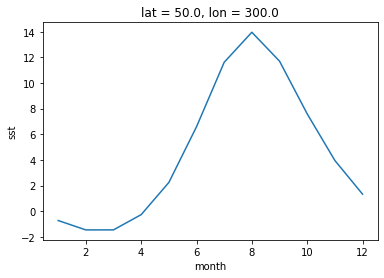

In [50]:
# 北大西洋特定格点的多年月平均气候序列
gb.mean(dim="time").sst.sel(lon=300, lat=50).plot()

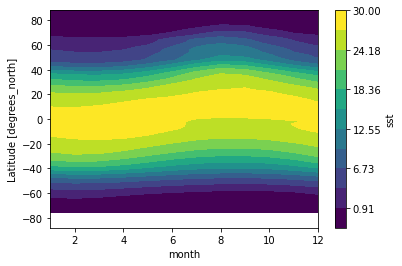

In [51]:
# 多年纬度月平均气候场
gb.mean(dim="time").sst.mean(dim="lon").plot.contourf(x="month", levels=12, vmin=-2, vmax=30)

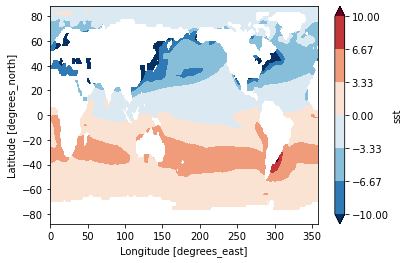

In [52]:
# 多年1月与7月平均气候场之间的差异
(gb.mean(dim="time").sst.sel(month=1) - gb.mean(dim="time").sst.sel(month=7)).plot.contourf(vmax=10)

### 转换

下面需从数据集中删除气候平均，从而得到变量随气候平均态变化的残差。一般将这个残差称为距平。

对转换（Transformations）操作而言，消除数据的气候平均是一个很好的例子。
转换操作对分组的对象进行操作，但不改变原数据的维度尺寸。

xarray 通过使用Groupby 算法使这些类型的转换变得容易。下面给出了计算去除月份温度差异的海温月数据。

In [53]:
# 对 12 组中的对应组的海温数据（这个组内的每一天的海温数据）减去平均的海温数据
remove_time_mean = lambda a: a-a.mean(dim="time")
gb.map(remove_time_mean)

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 708)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01
Data variables:
    sst      (time, lat, lon) float32 9.537e-07 9.537e-07 9.537e-07 ... nan nan

也可以简写为下面这种形式

In [54]:
# 对 12 组中的对应组的海温数据（这个组内的每一天的海温数据）减去平均的海温数据
ds_anom = gb - gb.mean(dim="time")
ds_anom

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 708)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (time, lat, lon) float32 9.537e-07 9.537e-07 9.537e-07 ... nan nan

当经过上述去除季节性周期的影响后，便很容易发现气候变率的信号。

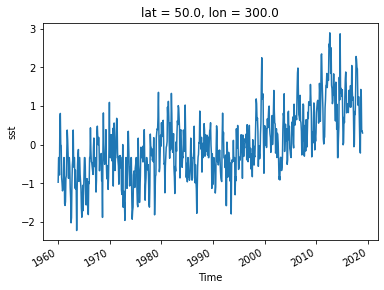

In [55]:
# 北大西洋单点的时间序列
ds_anom.sst.sel(lon=300, lat=50).plot()

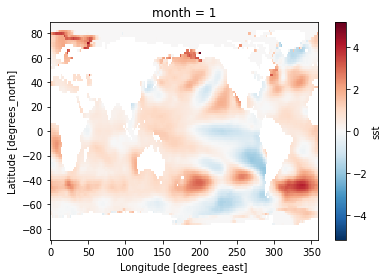

In [56]:
# 2018 年 1 月 1 日与 1960 年 1 月 1 日之间 SST 之间的差异
(ds_anom.sel(time="2018-01-01") - ds_anom.sel(time="1960-01-01")).sst.plot()

# Resample重采样

xarray 中的Resample（重采样）的处理方法与 Pandas 包几乎相同。就本质而言，Resample 也是一个分割数据的操作。  
它与分割操作的基本语法类似。应当注意，对于 Resample 操作而言，其作用对象必须是时间维度。 

_**<font color=skyblue size=4><font color=orange>ds</font>.resample( <font color=orange>time="freq"</font> )</font>**_  

为说明 Resample 的用法，下面给出一个例子计算逐五年的平均值曲线。 

对于 Resample 操作而言，与 Groupby 操作非常类似，首先也创建了一个DatasetResample对象。  
.resample(time="5Y")是对时间进行重采样进行设置，维度为time，设置的时间间隔为 5 年。  
应当指出这里的时间间隔写法与之前pd.date_range函数中的freq的时间间隔的关键词是一致的。

In [57]:
resample_obj = ds_anom.resample(time="5Y")
resample_obj

DatasetResample, grouped over '__resample_dim__'
13 groups with labels 1960-12-31, ..., 2020-12-31.

然后对这些分割好的 Resample 对象进行取平均，以便获得每一个分组好的 Resample 对象中的平均值。

In [58]:
ds_anom_resample = resample_obj.mean(dim="time")
ds_anom_resample

<xarray.Dataset>
Dimensions:  (time: 13, lat: 89, lon: 180)
Coordinates:
  * time     (time) datetime64[ns] 1960-12-31 1965-12-31 ... 2020-12-31
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
Data variables:
    sst      (time, lat, lon) float32 -0.0006173 -0.0006063 ... nan nan

为了说明进行重采样后的效果，下面来看一下(50°N, 60°E)的海温变化情况

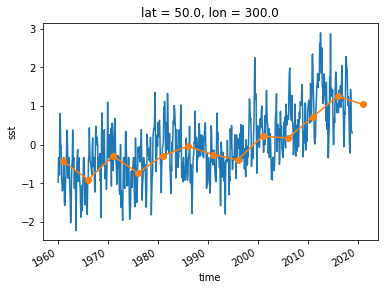

In [59]:
# 原始海温变化的时间序列
ds_anom.sst.sel(lon=300, lat=50).plot() 
# 逐5年平均的海温变化的时间序列
ds_anom_resample.sst.sel(lon=300, lat=50).plot(marker="o") 

# Coarsen（粗化）

coarsen（粗化）所做的事情与resample（重采样）类似。  
resample仅可用于时间坐标，但coarsen对逻辑坐标和时间坐标均可使用。  
同时coarsen不仅能作用一个维度，还可作用多个维度。粗化方法通常用来降低xarray对象的分辨率。

In [60]:
ds_anom.sst.isel(time = 0).coords

Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
    time     datetime64[ns] 1960-01-01
    month    int64 1

采用粗化的方法将其重采样至 5×10 的分辨率

_**<font color=skyblue size=4><font color=orange>ds</font>.coarsen( <font color=orange>dim1=size1</font>, <font color=orange>dim2=size2</font>, ..., <font color=orange>boundary</font> )</font>**_  

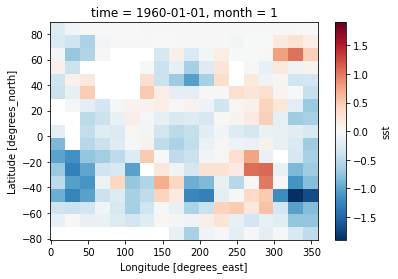

In [61]:
ds_anom.sst.coarsen(
    lat=5, 
    lon=10, 
    boundary="trim"
).mean().isel(time=0).plot()

boundary 变量规定了如何处理数组尺寸与窗口尺寸之间不是倍数的情况。  
若为trim，多余的不能整除的数据将被直接剔除；若为pad，则将其填充为 nan.

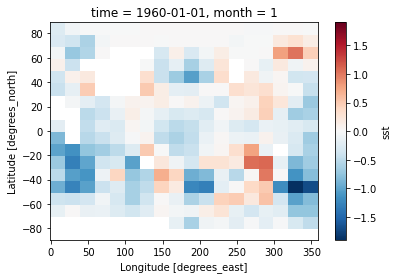

In [62]:
ds_anom.sst.coarsen(
    lat=5, 
    lon=10, 
    boundary="pad"
).mean().isel(time=0).plot()

对时间维的重采样，resample和coarsen均可有类似的结果。

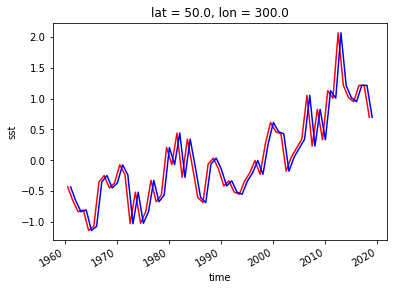

In [63]:
ds_anom_ = ds_anom.sst.sel(lon=300, lat=50)
ds_anom_.coarsen (time=12, boundary= "pad").mean().plot(c="r")
ds_anom_.resample(time="Y").mean().plot(c="b")

最后对比一下逐12个日期平均和12个月滑动平均的曲线

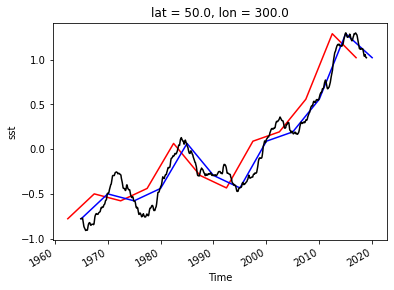

In [64]:
# 5年平均序列 coarsen
ds_anom_coarsen_time = ds_anom.coarsen(time=12*5, boundary="pad").mean()
ds_anom_coarsen_time.sst.sel(lon=300, lat=50).plot(c="r")
# 5年平均序列 resample
ds_anom_coarsen_time = ds_anom.resample(time="5Y", closed="left").mean()
ds_anom_coarsen_time.sst.sel(lon=300, lat=50).plot(c="b")
# 5年滑动平均
ds_anom_rolling = ds_anom.rolling(time=12*5).mean()
ds_anom_rolling.sst.sel(lon=300, lat=50).plot(c="k")

# Rolling 滑动平均

Rolling 方法也与pandas 包中的类似，但是稍有不同的是，它可适用于任意维度。如果将其作用于时间维度，也可称之为滑动平均。

_**<font color=skyblue size=4><font color=orange>ds</font>.rolling( <font color=orange>dim</font>, <font color=orange>center</font> )</font>**_  

time=12指定了对维度time以 12 个月为周期（月数据）变动时间窗，  
center=True表明以当前窗的两侧筛选数据，否则是以当前窗的前 12 个月作为筛选目标（包括本身）

In [65]:
ds_anom_rolling = ds_anom.rolling(time=12*5, center=True).mean()
ds_anom_rolling

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 708)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

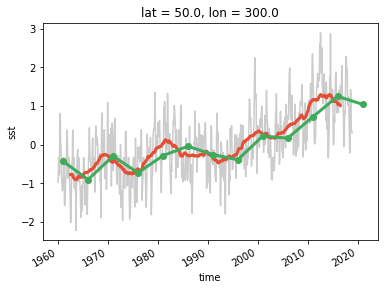

In [66]:
# 原始海温变化的时间序列
ds_anom.sst.sel(lon=300, lat=50).plot(color="#CCCCCC") 
# 5年滑动平均的海温变化的时间序列
ds_anom_rolling.sst.sel(lon=300, lat=50).plot(color="#E54E35", linewidth=3) 
# 逐5年平均的海温变化的时间序列
ds_anom_resample.sst.sel(lon=300, lat=50).plot(color="#3FAA59", marker="o", linewidth=3) 

### 为了更好的说明 Rolling 的作用，下面举一个简单的例子说明其功能。

In [67]:
da = xr.DataArray(
    np.linspace(0, 11, 12),
    dims="time",
    coords=[
        pd.date_range("1999-12-15",periods=12,freq=pd.DateOffset(months=1))
    ]
)
da

<xarray.DataArray (time: 12)>
array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])
Coordinates:
  * time     (time) datetime64[ns] 1999-12-15 2000-01-15 ... 2000-11-15

In [68]:
da.rolling(time=5, center=True).mean()

<xarray.DataArray (time: 12)>
array([nan, nan,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., nan, nan])
Coordinates:
  * time     (time) datetime64[ns] 1999-12-15 2000-01-15 ... 2000-11-15

若时间窗为偶数值，那么对应中心位置将会在平均位置偏右侧

In [69]:
da.rolling(time=4, center=True).mean()

<xarray.DataArray (time: 12)>
array([nan, nan, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, nan])
Coordinates:
  * time     (time) datetime64[ns] 1999-12-15 2000-01-15 ... 2000-11-15

若不指定参数center=True，则采用从当前元素往前筛选的方法

In [70]:
da.rolling(time=5).mean()

<xarray.DataArray (time: 12)>
array([nan, nan, nan, nan,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])
Coordinates:
  * time     (time) datetime64[ns] 1999-12-15 2000-01-15 ... 2000-11-15

当然和 grouby 对象类似，也可用 list 来访问每一个滑动窗

In [71]:
rolling_obj = da.rolling(time=5)
list(rolling_obj)[4][1]

<xarray.DataArray (time: 5)>
array([0., 1., 2., 3., 4.])
Coordinates:
  * time     (time) datetime64[ns] 1999-12-15 2000-01-15 ... 2000-04-15

# 线性多项式回归

.polyfit方法实现了回归功能，  
第一个参数"time"指定拟合坐标为time，  
第二数字参数指定为一元线性回归，  
full = True代表回归方法不仅要返回拟合系数（一元回归即斜率和截距）还应当返回残差，矩阵秩和奇异值。

_**<font color=skyblue size=4><font color=orange>ds</font>.polyfit( <font color=orange>dim</font>, <font color=orange>degree</font>, <font color=orange>full</font> )</font>**_  

In [72]:
ds_poly = ds_anom.sst.polyfit("time", 1, full=True)
ds_poly

<xarray.Dataset>
Dimensions:               (degree: 2, lat: 89, lon: 180)
Coordinates:
  * degree                (degree) int64 1 0
  * lat                   (lat) float64 88.0 86.0 84.0 ... -84.0 -86.0 -88.0
  * lon                   (lon) float64 0.0 2.0 4.0 6.0 ... 354.0 356.0 358.0
Data variables:
    time_matrix_rank      int64 2
    time_singular_values  (degree) float64 1.324 0.4976
    polyfit_coefficients  (degree, lat, lon) float64 1.829e-21 1.793e-21 ... nan
    polyfit_residuals     (lat, lon) float64 0.1355 0.1509 0.1622 ... nan nan

线性趋势（斜率）

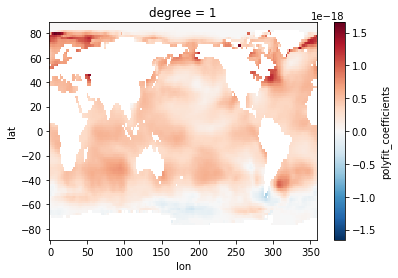

In [73]:
ds_poly.polyfit_coefficients.isel(degree=0).plot()

截距空间分布

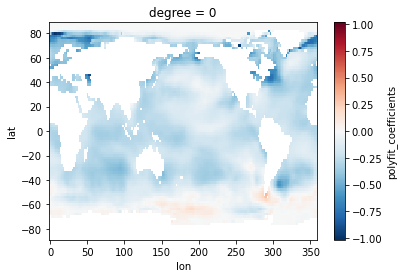

In [74]:
ds_poly.polyfit_coefficients.isel(degree=1).plot()